In [18]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [19]:
import yfinance as yf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
import joblib

In [20]:
!pip install yfinance


In [21]:
# Download historical stock data
ticker = "AAPL" # Example: Apple Inc.
data = yf.download(ticker, start="2015-01-01", end="2023-12-31")
data.to_csv('stock_data.csv') # Save the data to a CSV file

print(data.head())

[*********************100%***********************]  1 of 1 completed

Price           Close       High        Low       Open     Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                             
2015-01-02  24.347174  24.817059  23.906238  24.805924  212818400
2015-01-05  23.661270  24.195737  23.474208  24.115567  257142000
2015-01-06  23.663502  23.924054  23.300509  23.725856  263188400
2015-01-07  23.995317  24.095529  23.761488  23.872835  160423600
2015-01-08  24.917267  24.975168  24.206871  24.324901  237458000


In [22]:
# Load the data
data = pd.read_csv('stock_data.csv')

In [23]:
# Inspect the dataset
print("First few rows of data:")
print(data.head())
print("\nData types:")
print(data.dtypes)
print("\nMissing values:")
print(data.isnull().sum())

First few rows of data:
        Price               Close                High                Low  \
0      Ticker                AAPL                AAPL               AAPL   
1        Date                 NaN                 NaN                NaN   
2  2015-01-02    24.3471736907959  24.817058905170082  23.90623813027048   
3  2015-01-05  23.661270141601562  24.195736818722285  23.47420773907181   
4  2015-01-06  23.663501739501953   23.92405371719302  23.30050886726034   

                 Open     Volume  
0                AAPL       AAPL  
1                 NaN        NaN  
2  24.805923508061987  212818400  
3   24.11556673220304  257142000  
4  23.725855884690617  263188400  

Data types:
Price     object
Close     object
High      object
Low       object
Open      object
Volume    object
dtype: object

Missing values:
Price     0
Close     1
High      1
Low       1
Open      1
Volume    1
dtype: int64


In [24]:
# Convert relevant columns to numeric
numeric_columns = ['Close', 'High', 'Low', 'Open', 'Volume'] #Adjust based on your dataset
for col in numeric_columns:
    data[col] = pd.to_numeric(data[col], errors='coerce') # Convert to numeric, invalid values become NaN

In [25]:
# Drop rows with missing or invalid data
data = data.dropna()

In [26]:
# Verify cleaning
print("\nAfter cleaning:")
print(data.isnull().sum())
print(data.head())


After cleaning:
Price     0
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64
        Price      Close       High        Low       Open       Volume
2  2015-01-02  24.347174  24.817059  23.906238  24.805924  212818400.0
3  2015-01-05  23.661270  24.195737  23.474208  24.115567  257142000.0
4  2015-01-06  23.663502  23.924054  23.300509  23.725856  263188400.0
5  2015-01-07  23.995317  24.095529  23.761488  23.872835  160423600.0
6  2015-01-08  24.917267  24.975168  24.206871  24.324901  237458000.0


In [27]:
# Scaling 'Close' prices for LSTM
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[['Close']])

In [28]:
# Save the scaler for future use (for consistent scaling)
joblib.dump(scaler, 'scaler.pkl') # Save the scaler

['scaler.pkl']

In [29]:
# Train/test split (80% train, 20% test)
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

In [30]:
# Print shapes of train/test sets
print("\nTrain data shape:", train_data.shape)

print("Test data shape:", test_data.shape)


Train data shape: (1811, 1)
Test data shape: (453, 1)


In [31]:
# Prepare features and labels for Linear Regression
X = data.index.values.reshape(-1, 1) # Date as feature
y = data['Close'].values # Closing prices as label

In [32]:
# Train/test split for Linear Regression
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
random_state=42)

In [33]:
# Train Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression()

In [34]:
# Predictions
y_pred = lr_model.predict(X_test)

In [35]:
# Evaluate the model
print("MSE (Linear Regression):", mean_squared_error(y_test,
y_pred))
print("R2 Score (Linear Regression):", r2_score(y_test, y_pred))

MSE (Linear Regression): 386.6939583995942
R2 Score (Linear Regression): 0.8821719120641209


In [41]:
X_train_lstm, y_train_lstm = [], []

for i in range(60, len(train_data)):
    X_train_lstm.append(train_data[i-60:i])
    y_train_lstm.append(train_data[i])

# Convert lists to NumPy arrays AFTER the loop
X_train_lstm, y_train_lstm = np.array(X_train_lstm), np.array(y_train_lstm)


In [42]:
# Design LSTM Model
lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True,
input_shape=(X_train_lstm.shape[1], 1)))
lstm_model.add(LSTM(50))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

c:\Users\KIIT\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [43]:
# Train the LSTM model
lstm_model.fit(X_train_lstm, y_train_lstm, epochs=20,
batch_size=32)

Epoch 1/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - loss: 0.0201
Epoch 2/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 4.0428e-04
Epoch 3/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 4.0060e-04
Epoch 4/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 3.7337e-04
Epoch 5/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 3.1440e-04
Epoch 6/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 2.9679e-04
Epoch 7/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 2.5273e-04
Epoch 8/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 3.3554e-04
Epoch 9/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 2.7078e-04
Epoch 10/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 2.5553e-04
Epoch 11/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 2.2878e-04
Epoch 12/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 2.1199e-04
Epoch 13/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 2.2536e-04
Epoch 14/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 2.7696e-04
Epoch 15/20
55/55 ━

In [44]:
# Predictions using LSTM (here you'll need to prepare test data for LSTM as well)
lstm_predictions = lstm_model.predict(X_train_lstm) # Example: Use the training set for prediction (you can replace with test set)

55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step


In [45]:
# Compare MSE for Linear Regression and LSTM
print("Linear Regression MSE:", mean_squared_error(y_test, y_pred))
print("LSTM MSE:", mean_squared_error(y_train_lstm, lstm_predictions))

Linear Regression MSE: 386.6939583995942
LSTM MSE: 0.00016628956356127276


In [46]:
# Save the Linear Regression model
joblib.dump(lr_model, 'linear_regression_model.pkl')

['linear_regression_model.pkl']

In [47]:
# Save the LSTM model
lstm_model.save('lstm_model.keras')

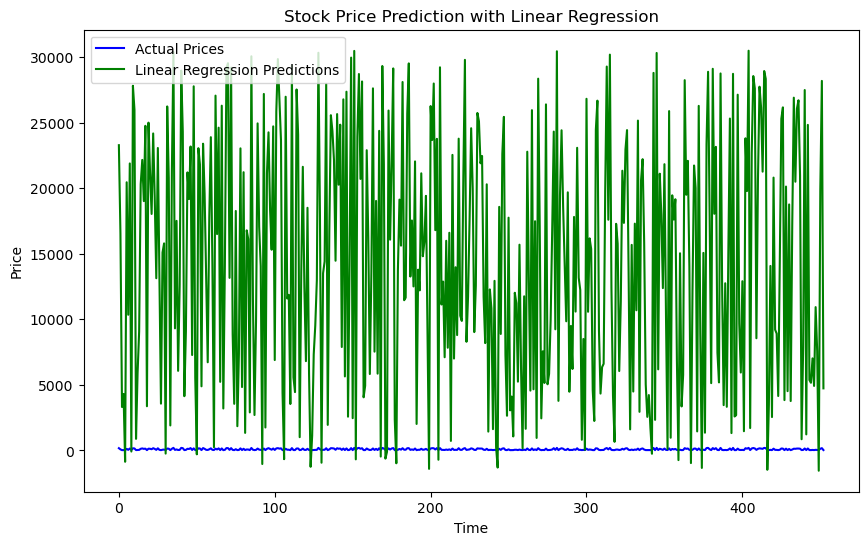

In [48]:
# Plot Linear Regression predictions
original_predictions_lr = scaler.inverse_transform(y_pred.reshape(-1, 1))
plt.figure(figsize=(10, 6))
plt.plot(y_test, label="Actual Prices", color="blue")
plt.plot(original_predictions_lr, label="Linear Regression Predictions", color="green")
plt.title("Stock Price Prediction with Linear Regression")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()

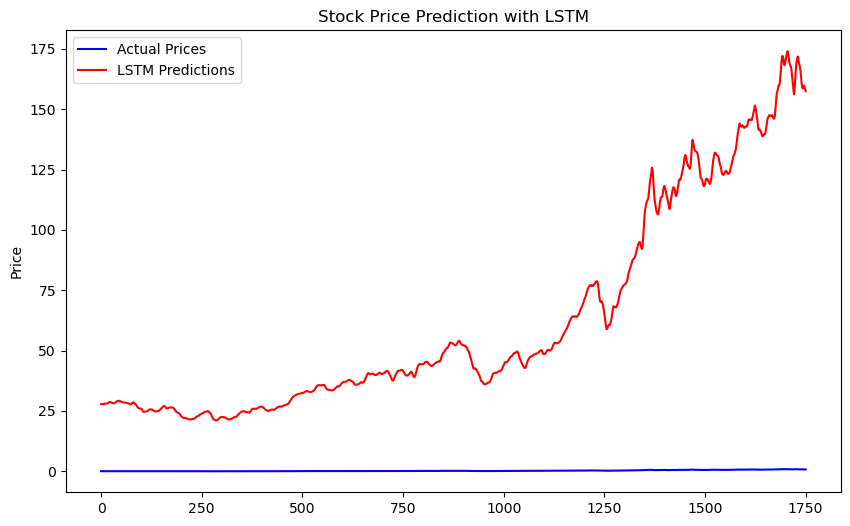

In [49]:
# Plot LSTM predictions (inverse scaling required for LSTM)
original_predictions_lstm = scaler.inverse_transform(lstm_predictions.reshape(-1, 1))
plt.figure(figsize=(10, 6))
plt.plot(y_train_lstm, label="Actual Prices", color="blue")
plt.plot(original_predictions_lstm, label="LSTM Predictions", color="red")
plt.title("Stock Price Prediction with LSTM")
plt.ylabel("Price")
plt.legend()
plt.show()

In [56]:
from flask import Flask, request, render_template, jsonify
import yfinance as yf
from datetime import datetime
import joblib
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model

# Load pre-trained models
lr_model = joblib.load('linear_regression_model.pkl')  # Linear Regression model
lstm_model = load_model('lstm_model.keras')  # LSTM model
scaler = joblib.load('scaler.pkl')  # Scaler for inverse scaling

# Initialize Flask app
app = Flask(__name__)

@app.route('/')
def index():
    return render_template('index.html')

@app.route('/predict', methods=['POST'])
def predict():
    # Get user input from the form
    stock_symbol = request.form.get('stock_symbol')  # Stock symbol (e.g., 'AAPL')
    input_date = request.form.get('date')  # Date in YYYY-MM-DD format

    # Convert the input date to a datetime object
    try:
        input_date = datetime.strptime(input_date, '%Y-%m-%d')
    except ValueError:
        return jsonify({"error": "Invalid date format. Use YYYY-MM-DD."})

    # Ensure the date is in the future
    if input_date < datetime.today():
        return jsonify({"error": "Please enter a future date for prediction."})

    # Fetch historical stock data for the symbol
    data = yf.download(stock_symbol, start="2015-01-01", end=datetime.today().strftime('%Y-%m-%d'))
    if data.empty:
        return jsonify({"error": f"No data found for the stock symbol: {stock_symbol}."})

    # Prepare data for prediction (Linear Regression and LSTM models)
    X = np.array(range(len(data))).reshape(-1, 1)  # Using the date index as the feature
    y = data['Close'].values  # Closing prices as the target variable

    # Linear Regression prediction for the next day
    lr_prediction = lr_model.predict(np.array([[len(data)]]))  # Predicting for the next day
    lr_prediction = scaler.inverse_transform(lr_prediction.reshape(-1, 1))[0][0]  # Inverse scaling

    # Prepare data for LSTM model (using the last 60 days as input)
    last_60_days = data['Close'].values[-60:]  # Last 60 days of closing prices
    last_60_days_scaled = scaler.transform(last_60_days.reshape(-1, 1))  # Scale it
    X_input = last_60_days_scaled.reshape((1, 60, 1))  # Reshaped for LSTM input

    # LSTM prediction
    lstm_prediction = lstm_model.predict(X_input)
    lstm_prediction = scaler.inverse_transform(lstm_prediction.reshape(-1, 1))[0][0]  # Inverse scaling

    # Return predictions as JSON
    return jsonify({
        'linear_regression_prediction': float(lr_prediction),
        'lstm_prediction': float(lstm_prediction),
        'prediction_date': input_date.strftime('%Y-%m-%d')
    })

if __name__ == '__main__':
    app.run(debug=True)


 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
 * Restarting with watchdog (windowsapi)


SystemExit: 1

c:\Users\KIIT\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
